# Revert Rate

We'll investigate revert rate for the Add an Image experiment the same way as we did for Add a Link, with a zero/one-inflated beta model in `brms`

In [1]:
library(tidyverse)
library(broom)

library(brms) # install.packages("brms")
library(loo) # install.packages("loo")
library(rstanarm) # install.packages("rstanarm")

library(lubridate)
library(bayesplot)

#library(lme4)
#library(yardstick) # install.packages("yardstick")

#library(caret)

Warning message:
“package ‘tidyverse’ was built under R version 4.2.3”
Warning message:
“package ‘tibble’ was built under R version 4.2.3”
Warning message:
“package ‘tidyr’ was built under R version 4.2.3”
Warning message:
“package ‘readr’ was built under R version 4.2.3”
Warning message:
“package ‘purrr’ was built under R version 4.2.3”
Warning message:
“package ‘dplyr’ was built under R version 4.2.3”
Warning message:
“package ‘stringr’ was built under R version 4.2.3”
Warning message:
“package ‘forcats’ was built under R version 4.2.3”
Warning message:
“package ‘lubridate’ was built under R version 4.2.3”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.3     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()

# R Configuration variables

In [2]:
## NOTE: `loo`, which we use for model comparisons, has a tendency to use lots or run out of memory.
## Therefore, I've often had to set mc.cores to 1 before running it. However, if we set its `pointwise`
## parameter, it'll use less memory. And it'll use BLAS, so we restrict the number of BLAS threads to 1.
## Then mc.cores controls the number of parallel processes.

## blas_set_num_threads() also controls the number of threads that glmer() uses. Depending on the load
## on the server at the time we're doing our analysis we can tune the number of threads.

library(RhpcBLASctl)
blas_set_num_threads(1)
options(mc.cores = 4, digits = 3, scipen = 500)

# Give me wider plots, please
options(repr.plot.width = 14, repr.plot.height = 7)

Warning message:
“package ‘RhpcBLASctl’ was built under R version 4.2.3”


# Helper functions

In [3]:
## Function that takes in a model, the validation set, the name of the predicted column,
## and returns a plot of the ROC curve
plot_ROC <- function(mod, val_data, col_name) {
    val_data$estimate = predict(mod, val_data, type = "response")
    roc_curve(val_data, {{ col_name }}, estimate, event_level = 'second') %>%
        ggplot(aes(x = 1 - specificity, y = sensitivity)) +
        geom_path() +
        geom_abline(lty = 3) +
        coord_equal() +
        theme_bw()
}

In [4]:
## Function that takes in the filename of the user edit data, reads it in,
## and creates all the various derived columns we need.
read_user_dataset <- function(dataset_filename) {
    read_tsv(
        dataset_filename,
        col_types = user_dataset_column_types) %>%
    mutate(
        Group = factor(hp_enabled, levels = c(0, 1), labels = c("C", "HP")),
        platform = factor(reg_on_mobile == 1, c(FALSE, TRUE), c("desktop", "mobile")),
        ## Registration month, for later joins on month
        reg_month = floor_date(user_registration_timestamp, unit = 'month'),
        # Number of edits:
        num_total_edits_24hrs = num_article_edits_24hrs + num_other_edits_24hrs,
        num_total_edits_2w = num_article_edits_2w + num_other_edits_2w,
        num_total_edits = num_total_edits_24hrs + num_total_edits_2w,
        num_total_article_edits = num_article_edits_24hrs + num_article_edits_2w,
        num_total_other_edits = num_other_edits_24hrs + num_total_edits_2w,
        # Log number of total edits is used as a control variable in the revert analysis
        log_num_total_edits = log(1 + num_total_edits),
        # Number of reverts:
        num_reverts_24hrs = num_article_reverts_24hrs + num_other_reverts_24hrs,
        num_reverts_2w = num_article_reverts_2w + num_other_reverts_2w,
        num_total_reverts = num_reverts_24hrs + num_reverts_2w,
        ## Control variables for the number of edits made (used for ex. in revert analysis)
        log_num_article_edits_24hrs = log(1 + num_article_edits_24hrs),
        log_num_other_edits_24hrs = log(1 + num_other_edits_24hrs),
        log_num_edits_24hrs = log(1 + num_article_edits_24hrs + num_other_edits_24hrs),
        # Control variables for the number of constructive edits made
        log_num_const_article_edits_24hrs = log(
            1 + num_article_edits_24hrs - num_article_reverts_24hrs),
        log_num_const_other_edits_24hrs = log(
            1 + num_other_edits_24hrs - num_other_reverts_24hrs),
        log_num_const_edits_24hrs = log(
            1 + num_article_edits_24hrs + num_other_edits_24hrs -
                num_article_reverts_24hrs - num_other_reverts_24hrs),
        # Revert rate:
        prop_rev_edits = ifelse(num_total_edits > 0, num_total_reverts / num_total_edits, 0),
        # Did they activate?
        is_activated_article = num_article_edits_24hrs > 0,
        is_activated_other = num_other_edits_24hrs > 0,
        is_activated = is_activated_article | is_activated_other,
        # Did they activate through constructive edits?
        is_const_activated_article = (num_article_edits_24hrs - num_article_reverts_24hrs) > 0,
        is_const_activated_other = (num_other_edits_24hrs - num_other_reverts_24hrs) > 0,
        is_const_activated = is_const_activated_article | is_const_activated_other,
        # Were they retained?
        is_retained_article = is_activated_article & (num_article_edits_2w > 0),
        is_retained_other = is_activated_other & (num_other_edits_2w > 0),
        is_retained = is_activated & ((num_article_edits_2w + num_other_edits_2w) > 0),
        # Were they retained through constructive edits?
        is_const_retained_article = is_const_activated_article &
            ((num_article_edits_2w - num_article_reverts_2w) > 0),
        is_const_retained_other = is_const_activated_other &
            ((num_other_edits_2w - num_other_reverts_2w) > 0),
        is_const_retained = is_const_activated &
            ((num_article_edits_2w + num_other_edits_2w -
              num_article_reverts_2w - num_other_reverts_2w) > 0)
    ) 
}

In [5]:
## Function that takes in the filename of the active editors dataset,
## and adds a registration month column for easy joining with the user dataset.
read_active_editors_dataset <- function(dataset_filename) {
    read_tsv(
        dataset_filename,
        col_types = active_editors_column_types) %>%
    mutate(wiki_db = factor(wiki_db),
           reg_month = month + months(1))
}

# Experiment Configuration Variables

We define a set of configuration variables that are useful for the analysis. One obvious one is where the edit dataset is located.

A less obvious one is a variable for when the experiment started. We often use this seeking to model the community's initial response to changes in newcomer behaviour, as well as long-term trends in the outcome variable when working with user data gathered across a relatively long time period.

In [6]:
## Path to the datasets with user edits
user_dataset_filenames <- c(
    '/home/nettrom/src/2021-Growth-structured-tasks/datasets/add-an-image-edit-data.tsv'
    )

## Column types in the dataset: wiki is a factor, HP variant is a factor, registration is a date time,
## everything else are integers.
user_dataset_column_types <- 'fiTiifiiiiiiii'

## Path to the dataset with counts of the number of active editors
active_editors_filenames <- c()

## Column types in the active editors dataset: month is a date, wiki is a factor
active_editors_column_types <- 'Dfiii'

## Deployment timestamps for Add an Image on each of the wikis
## This is not relevant for this, because we "reset" the experiment and
## gather data well after deployment.
exp_start_timestamps <- tribble(
    ~wiki_db, ~exp_start_timestamp,
    'arwiki', ymd_hms('2021-05-27 19:12:03', tz = 'UTC'),

) %>% mutate(wiki_db = factor(wiki_db))

## Path to the dataset with editing status at account registration
editing_status_filenames <- c()

## Column types in the editing status dataset: wiki is a factor, everything else are integers
editing_status_column_types <- 'fii'

## Path to the dataset with Welcome Survey responses
survey_response_filenames <- c()

## Columns types in the survey response data: user ID is an integer, number of languages is a number,
## everything else are factors
survey_response_column_types <- 'fifffn'

# Data import and setup

In [7]:
user_edit_data <- map_dfr(user_dataset_filenames, read_user_dataset)

In [8]:
nrow(user_edit_data)

[1] 148419

## Time since experiment start

Join the edits data with the experiment timestamps and measure time since the start to enable controlling for that:

Made sure that we're not dropping any users at this stage, we're good to move forward.

## Additional variables

We've previously focused on Control vs Growth Features in our analysis. In this case we'll focus primarily on Unstructured Link Task vs Add a Link, but also check against the control group. This means we want the single variable `Group` to reflect one of three options depending on `hp_enabled` and `hp_variant`

In [9]:
user_edit_data <- user_edit_data %>%
    mutate(
        platform = ifelse(reg_on_mobile == 1, 'Mobile web', 'Desktop'),
        exp_group = factor(
            ifelse(
                hp_enabled == 0, 'Control',
                ifelse(hp_variant == 'control',
                       'Add-a-Link', 'Add-an-Image')
            ),
            c('Control', 'Add-a-Link', 'Add-an-Image')
        )
    )

## Checking number of accounts for each wiki

We might be looking at very small wikis, in case we might want to not include them in the analysis.

In [ ]:
user_edit_data %>%
    group_by(wiki_db, exp_group) %>%
    summarize(n = n())

## Splitting into Training, Test, and Validation Datasets

Split the dataset into training, test, and validation data sets.

In [ ]:
## set the random seed so train/test/validation splits can be reproduced
set.seed(42)

trainIndex <- caret::createDataPartition(user_edit_data$Group,
                                         p = .8,
                                         list = FALSE,
                                         times = 1)
user_data_train = user_edit_data[trainIndex,]
user_data_second = user_edit_data[-trainIndex,]

testIndex = caret::createDataPartition(user_data_second$Group, p = .5, list = FALSE, times = 1)

user_data_test = user_data_second[testIndex,]
user_data_validate = user_data_second[-testIndex,]

In [ ]:
user_data_test$is_activated_fct <- factor(user_data_test$is_activated,
                                          labels = c('No', 'Yes'))
user_data_validate$is_activated_fct <- factor(user_data_validate$is_activated,
                                          labels = c('No', 'Yes'))

## Visualization of revert rates overall

This plots a histogram of revert rates for users that did not have either 0% or 100% reverts.

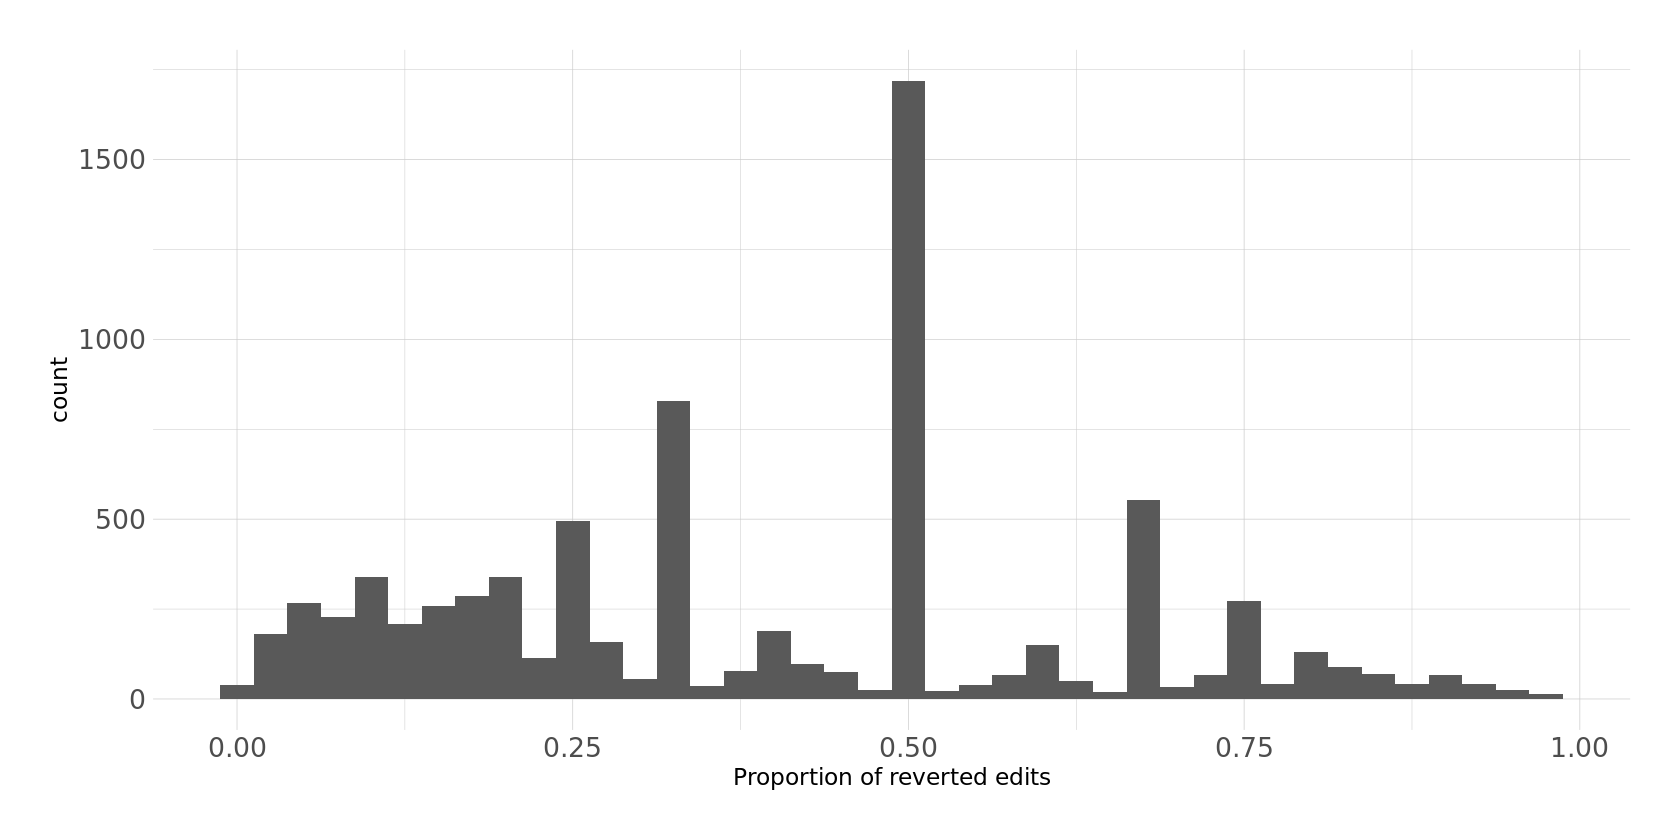

In [11]:
options(repr.plot.width = 14, repr.plot.height = 7)

user_edit_data %>%
    filter(num_total_edits > 0 & prop_rev_edits > 0 & prop_rev_edits < 1) %>%
    ggplot(aes(x = prop_rev_edits)) +
    geom_histogram(binwidth = 0.025) +
    hrbrthemes::theme_ipsum("DejaVu Sans", base_size = 16, strip_text_face = "bold", strip_text_size = 18,
                            caption_size = 12, axis_title_size = 14, subtitle_size = 14,
                            axis_title_just = 'cm') +
    scale_x_continuous("Proportion of reverted edits")

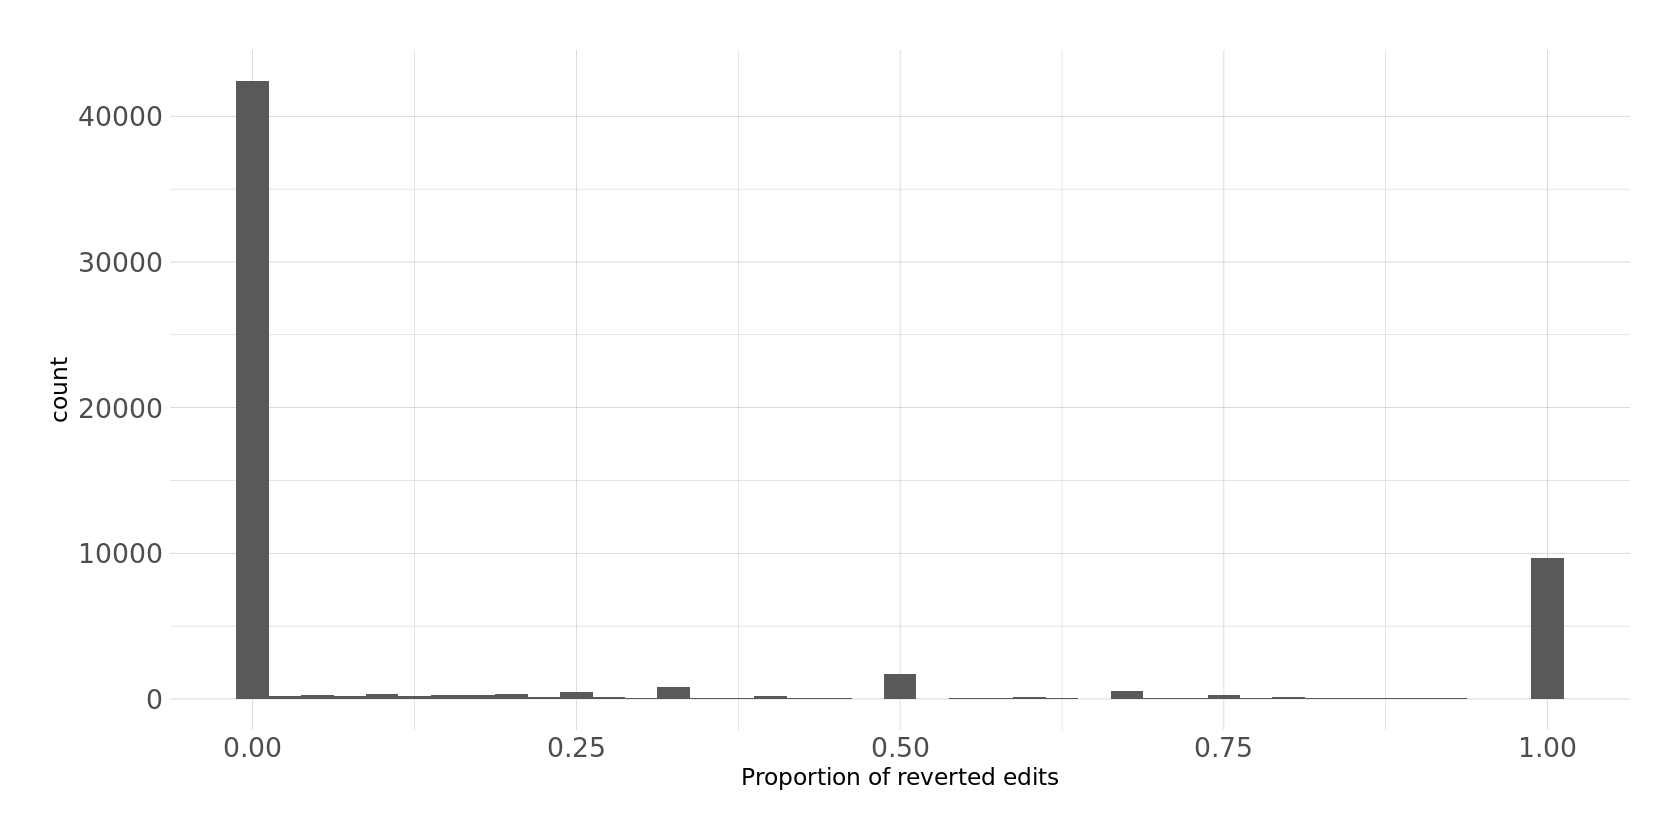

In [12]:
user_edit_data %>%
    filter(num_total_edits > 0) %>%
    ggplot(aes(x = prop_rev_edits)) +
    geom_histogram(binwidth = 0.025) +
    hrbrthemes::theme_ipsum("DejaVu Sans", base_size = 16, strip_text_face = "bold", strip_text_size = 18,
                            caption_size = 12, axis_title_size = 14, subtitle_size = 14,
                            axis_title_just = 'cm') +
    scale_x_continuous("Proportion of reverted edits")

## Revert rate split by wiki, platform, and group

This plot needs work as we now have 27 wikis in our dataset. I've removed it for now.

In [ ]:
user_edit_data %>%
    filter(num_total_edits > 0 & prop_rev_edits > 0 & prop_rev_edits < 1) %>%
    ggplot(aes(x = prop_rev_edits)) +
    geom_histogram(binwidth = 0.025, aes(y = ..count.. / sum(..count..))) +
    facet_grid(exp_group ~ platform) +
    coord_cartesian(ylim = c(0, 0.02)) +
    hrbrthemes::theme_ipsum("DejaVu Sans", axis_title_just = 'cm') +
    labs(x = 'Proportion of reverted edits', y = 'Proportion of users')

In [ ]:
user_edit_data %>%
    filter(num_total_edits > 0) %>%
    ggplot(aes(x = prop_rev_edits)) +
    geom_histogram(binwidth = 0.025, aes(y = ..count.. / sum(..count..))) +
    facet_grid(exp_group ~ platform) +
    coord_cartesian(ylim = c(0, 0.02)) +
    hrbrthemes::theme_ipsum("DejaVu Sans", axis_title_just = 'cm') +
    labs(x = 'Proportion of reverted edits', y = 'Proportion of users')

## NOTES

Not sure if it's worth fitting this first model at this point. We know from several previous analyses that number of edits is an important control factor, so why not include it from the start?

## Homepage only

Without controlling for other factors, does the Homepage appear to have an overall effect on revert rate?

In [13]:
zoib_formula.1 <- bf(
  prop_rev_edits ~ exp_group,
  phi ~ exp_group,
  zoi ~ exp_group,
  coi ~ exp_group, 
  family = zero_one_inflated_beta()
)

In [14]:
zoib_model.1 <- user_edit_data %>%
    filter(num_total_edits > 0) %>%
    brm(
        formula = zoib_formula.1,
        iter = 400
    )

Compiling Stan program...

Start sampling

Warning message:
“Bulk Effective Samples Size (ESS) is too low, indicating posterior means and medians may be unreliable.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#bulk-ess”


In [15]:
## save the model for reference
save(zoib_model.1, file='models/revert_rate_zoib_model.1.Robj')

Model summary:

In [16]:
summary(zoib_model.1)

 Family: zero_one_inflated_beta 
  Links: mu = logit; phi = log; zoi = logit; coi = logit 
Formula: prop_rev_edits ~ exp_group 
         phi ~ exp_group
         zoi ~ exp_group
         coi ~ exp_group
   Data: . (Number of observations: 59868) 
  Draws: 4 chains, each with iter = 400; warmup = 200; thin = 1;
         total post-warmup draws = 800

Population-Level Effects: 
                          Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS
Intercept                    -0.33      0.03    -0.40    -0.28 1.00      615
phi_Intercept                 1.19      0.04     1.11     1.27 1.00      417
zoi_Intercept                 1.91      0.03     1.85     1.97 1.00      602
coi_Intercept                -1.39      0.03    -1.45    -1.33 1.01      485
exp_groupAddMaMLink          -0.12      0.03    -0.18    -0.05 1.01      582
exp_groupAddManMImage        -0.10      0.04    -0.18    -0.03 1.00      598
phi_exp_groupAddMaMLink       0.07      0.05    -0.02     0.16 1.00      463
phi_e

## Distribution by number of edits

We examine whether there's a difference in the distribution of revert proportion by number of edits. Since the variable is skewed, we use a log scale for this. Handily, we already have variables for this in our dataset, and look mainly at the `log_num_total_edits` variable.

In [17]:
user_edit_data <- user_edit_data %>%
    mutate(log_num_total_edits = log(1 + num_total_edits))

In [18]:
summary(user_edit_data$log_num_total_edits)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00    0.00    0.00    0.49    0.69    7.44 

Make buckets based on the number of edits by flooring the log count.

In [19]:
user_edit_data$num_total_edits_bucket = floor(user_edit_data$log_num_total_edits)

In [ ]:
options(repr.plot.width = 14, repr.plot.height = 14)
user_edit_data %>%
    filter(num_total_edits > 0) %>%
    ggplot(aes(x = prop_rev_edits)) +
    geom_histogram(binwidth = 0.025, aes(y=..count../sum(..count..))) +
    hrbrthemes::theme_ipsum("DejaVu Sans", axis_title_just = 'cm') +
    labs(x = 'Proportion of reverted edits', y = 'Proportion of users') +
    facet_grid(num_total_edits_bucket ~ ., scales = "free_y")

In [21]:
user_edit_data <- user_edit_data %>%
    mutate(log2_num_total_edits = log2(num_total_edits))

Make buckets based on the number of edits by flooring the log count.

In [22]:
user_edit_data$num_total_edits_bucket_log2 = floor(user_edit_data$log2_num_total_edits)

In [ ]:
options(repr.plot.width = 14, repr.plot.height = 14)
user_edit_data %>%
    filter(num_total_edits > 0) %>%
    ggplot(aes(x = prop_rev_edits)) +
    geom_histogram(binwidth = 0.025, aes(y=..count../sum(..count..))) +
    hrbrthemes::theme_ipsum("DejaVu Sans", axis_title_just = 'cm') +
    labs(x = 'Proportion of reverted edits', y = 'Proportion of users') +
    facet_grid(num_total_edits_bucket_log2 ~ exp_group, scales = "free_y")

It's not a problem that the Y-axis isn't the same for each plot, because we're interested in understanding how the distribution changes based on edit count. What we can see is that the mean and precision of the beta distribution changes by edit count. Secondly, the probability of zero-or-one and the conditional probability of ones also changes. This suggests that we should incorporate number of edits into all four estimates in the model.

## Full Model

We reuse Model 6 from NEWTEA, because it used a hierarchical model rather than interaction between wiki and platform. Whenever we have a fairly large number of wikis (e.g. more than 3–4), that's definitely preferable. We'll continue to focus on the article namespace first, because that's where we've seen the most promising results.

In [11]:
user_edit_data <- user_edit_data %>%
    mutate(prop_rev_article_edits = ifelse(
        num_total_article_edits > 0, 
        (num_article_reverts_24hrs + num_article_reverts_2w) / num_total_article_edits, 0),
          log_num_total_article_edits = log(1 + num_total_article_edits))

In [26]:
zoib_formula.6 <- bf(
  prop_rev_article_edits ~ exp_group + log_num_total_article_edits + platform + (1 + platform | wiki_db),
  phi ~ exp_group + log_num_total_article_edits + platform + (1 + platform | wiki_db) ,
  zoi ~ exp_group + log_num_total_article_edits + platform + (1 + platform | wiki_db),
  coi ~ exp_group + log_num_total_article_edits + platform + (1 + platform | wiki_db),
  family = zero_one_inflated_beta()
)

In [ ]:
zoib_model.6 <- user_edit_data |>
    filter(
        (wiki_db != 'frwiki') &
        (num_total_article_edits > 0)
    ) |>
    brm(
        formula = zoib_formula.6,
        iter = 800,
        control = list(
            adapt_delta = 0.9
        )
    )

Compiling Stan program...

Start sampling



In [ ]:
## Save the model
save(zoib_model.6, file='models/revert_rate_zoib_model.6.Robj')

Model summary:

In [ ]:
summary(zoib_model.6)

In [51]:
fixef(zoib_model.6)

Estimate Est.Error Q2.5     Q97.5   
Intercept                        0.2257  0.0715     0.07841  0.36807
phi_Intercept                    3.2395  0.1206     2.99496  3.49969
zoi_Intercept                    4.9803  0.2452     4.49531  5.49190
coi_Intercept                   -1.3265  0.2432    -1.93953 -0.83255
exp_groupAddMaMLink             -0.0766  0.0340    -0.14573 -0.01576
exp_groupAddManMImage           -0.0813  0.0344    -0.15155 -0.01241
log_num_total_article_edits     -0.2768  0.0173    -0.30989 -0.24259
platformMobileweb                0.1429  0.0905    -0.05627  0.31038
phi_exp_groupAddMaMLink          0.0974  0.0562    -0.01770  0.20679
phi_exp_groupAddManMImage        0.1134  0.0555     0.00592  0.22245
phi_log_num_total_article_edits -0.7736  0.0264    -0.82535 -0.72445
phi_platformMobileweb           -0.1305  0.0987    -0.34606  0.04339
zoi_exp_groupAddMaMLink         -0.0335  0.0546    -0.14798  0.06794
zoi_exp_groupAddManMImage       -0.0388  0.0560    -0.14166  0.07372
zoi_log_num_total_article_edits -1.7750  0.0280    -1.82899 -1.71849
zoi_platformMobileweb           -0.5920  0.1937    -0.95972 -0.18171
coi_exp_groupAddMaMLink         -0.0795  0.0402    -0.15879 -0.00133
coi_exp_groupAddManMImage       -0.0659  0.0388    -0.13905  0.01233
coi_log_num_total_article_edits -0.2219  0.0259    -0.27345 -0.17386
coi_platformMobileweb            0.8115  0.2136     0.38982  1.23257

# Model with interaction between group and platform

In [30]:
zoib_formula.7 <- bf(
  prop_rev_article_edits ~ exp_group * platform + log_num_total_article_edits + (1 + platform | wiki_db),
  phi ~ exp_group * platform + log_num_total_article_edits + (1 + platform | wiki_db) ,
  zoi ~ exp_group * platform + log_num_total_article_edits + (1 + platform | wiki_db),
  coi ~ exp_group * platform + log_num_total_article_edits + (1 + platform | wiki_db),
  family = zero_one_inflated_beta()
)

In [ ]:
zoib_model.7 <- user_edit_data |>
    filter(
        (wiki_db != 'frwiki') &
        (num_total_article_edits > 0)
    ) |>
    brm(
        formula = zoib_formula.7,
        iter = 800,
        control = list(
            adapt_delta = 0.99
        )
    )

In [ ]:
## Save the model
save(zoib_model.7, file='models/revert_rate_zoib_model.7.Robj')

Model summary:

In [ ]:
summary(zoib_model.7)

In [ ]:
fixef(zoib_model.7)

Doesn't look like there are any interactions going on here. Running `loo` to confirm that Model 6 is the better choice.

In [54]:
zoib_model.6.loo = loo(
    zoib_model.6,
    pointwise = TRUE
)

In [55]:
zoib_model.7.loo = loo(
    zoib_model.7,
    pointwise = TRUE
)

In [56]:
loo_compare(
    zoib_model.6.loo,
    zoib_model.7.loo
)

elpd_diff se_diff elpd_loo se_elpd_loo p_loo se_p_loo looic
zoib_model.6  0.000    0.00    -23133   104         50.5  0.875    46267
zoib_model.7 -0.315    3.78    -23134   104         58.2  0.983    46267
             se_looic
zoib_model.6 208     
zoib_model.7 208

Yes, these results from `loo` indicate that the complexity isn't resulting in a better fit. We therefore choose to go with Model 6.

We now need to fit two models that include French Wikipedia, because interaction might show up there (we've seen it in other models).

## French Wikipedia

In [ ]:
zoib_model.8 <- user_edit_data |>
    filter(
        (exp_group != 'Control') &
        (num_total_article_edits > 0)
    ) |>
    brm(
        formula = zoib_formula.7,
        iter = 800,
        control = list(
            adapt_delta = 0.99,
            max_treedepth = 14
        )
    )

Compiling Stan program...

Start sampling



In [ ]:
## Save the model
save(zoib_model.8, file='models/revert_rate_zoib_model.8.Robj')

Model summary:

In [ ]:
summary(zoib_model.8)

In [73]:
fixef(zoib_model.8)

Estimate Est.Error Q2.5    Q97.5  
Intercept                                    0.2196  0.0660     0.0898  0.3504
phi_Intercept                                3.3349  0.1279     3.0854  3.5856
zoi_Intercept                                4.6283  0.1331     4.3682  4.9034
coi_Intercept                               -1.3178  0.1625    -1.6492 -1.0202
exp_groupAddManMImage                        0.0157  0.0312    -0.0442  0.0770
platformMobileweb                            0.1423  0.0797    -0.0176  0.2972
log_num_total_article_edits                 -0.3122  0.0163    -0.3443 -0.2811
exp_groupAddManMImage:platformMobileweb     -0.0381  0.0430    -0.1239  0.0454
phi_exp_groupAddManMImage                   -0.0261  0.0553    -0.1331  0.0826
phi_platformMobileweb                       -0.1550  0.1260    -0.4270  0.0760
phi_log_num_total_article_edits             -0.7601  0.0274    -0.8160 -0.7074
phi_exp_groupAddManMImage:platformMobileweb  0.0580  0.0771    -0.1023  0.2068
zoi_exp_groupAddManMImage                    0.0569  0.0521    -0.0419  0.1585
zoi_platformMobileweb                       -0.4276  0.1418    -0.7194 -0.1482
zoi_log_num_total_article_edits             -1.6466  0.0232    -1.6909 -1.6028
zoi_exp_groupAddManMImage:platformMobileweb -0.0847  0.0731    -0.2244  0.0557
coi_exp_groupAddManMImage                    0.0544  0.0380    -0.0207  0.1257
coi_platformMobileweb                        0.7739  0.2084     0.3597  1.2105
coi_log_num_total_article_edits             -0.2915  0.0257    -0.3427 -0.2445
coi_exp_groupAddManMImage:platformMobileweb -0.0796  0.0521    -0.1738  0.0225

Similar model but without the interaction between `exp_group` and `platform`:

In [ ]:
zoib_model.9 <- user_edit_data |>
    filter(
        (exp_group != 'Control') &
        (num_total_article_edits > 0)
    ) |>
    brm(
        formula = zoib_formula.6,
        iter = 800,
        control = list(
            adapt_delta = 0.99,
            max_treedepth = 14
        )
    )

Compiling Stan program...

Start sampling



In [ ]:
## Save the model
save(zoib_model.9, file='models/revert_rate_zoib_model.9.Robj')

Model summary:

In [ ]:
summary(zoib_model.9)

In [77]:
fixef(zoib_model.9)

Estimate Est.Error Q2.5    Q97.5  
Intercept                        0.23277 0.0696     0.0999  0.3699
phi_Intercept                    3.31999 0.1242     3.0737  3.5737
zoi_Intercept                    4.64777 0.1257     4.3860  4.8979
coi_Intercept                   -1.30452 0.1793    -1.6623 -0.9300
exp_groupAddManMImage           -0.00409 0.0210    -0.0471  0.0378
log_num_total_article_edits     -0.31220 0.0166    -0.3450 -0.2792
platformMobileweb                0.11560 0.0751    -0.0400  0.2634
phi_exp_groupAddManMImage        0.00498 0.0368    -0.0681  0.0768
phi_log_num_total_article_edits -0.76054 0.0282    -0.8162 -0.7077
phi_platformMobileweb           -0.12131 0.1087    -0.3427  0.0868
zoi_exp_groupAddManMImage        0.01258 0.0356    -0.0601  0.0820
zoi_log_num_total_article_edits -1.64555 0.0229    -1.6889 -1.6025
zoi_platformMobileweb           -0.47107 0.1286    -0.7403 -0.2223
coi_exp_groupAddManMImage        0.01015 0.0270    -0.0449  0.0632
coi_log_num_total_article_edits -0.28921 0.0256    -0.3389 -0.2402
coi_platformMobileweb            0.74495 0.2127     0.3219  1.1715

In [78]:
zoib_model.8.loo = loo(
    zoib_model.8,
    pointwise = TRUE
)

In [79]:
zoib_model.9.loo = loo(
    zoib_model.9,
    pointwise = TRUE
)

In [ ]:
loo_compare(
    zoib_model.8.loo,
    zoib_model.9.loo
)

## Overview Statistics

For the draft report, we gather a few statistics to get a sense of the revert rate per group. Based on the results for mobile registrations (higher revert rates), we should split this by platform.

As we've done elsewhere, we'll do this separately with and without French Wikipedia:

In [14]:
# Aggregate by platform and calculate average revert rate for users who edited
rate.platform.agg <- user_edit_data |>
    filter(
        (wiki_db != 'frwiki') &
        (num_total_article_edits > 0)
    ) |>
    group_by(platform, exp_group) %>%
    summarize(n = n(), mean_prop_rev_article_edits = mean(prop_rev_article_edits),
              mean_perc_rev_article_edits_rounded = round(100.0 * mean(prop_rev_article_edits), 1),
              .groups = 'keep') %>%
    group_by(platform, exp_group)
rate.platform.agg

platform   exp_group    n    mean_prop_rev_article_edits
1 Desktop    Control      2720 0.206                      
2 Desktop    Add-a-Link   5615 0.203                      
3 Desktop    Add-an-Image 5410 0.218                      
4 Mobile web Control      3287 0.376                      
5 Mobile web Add-a-Link   7276 0.349                      
6 Mobile web Add-an-Image 7342 0.342                      
  mean_perc_rev_article_edits_rounded
1 20.6                               
2 20.3                               
3 21.8                               
4 37.6                               
5 34.9                               
6 34.2

In [ ]:
## Calculate increase in percent
round(100.0 * (rate.platform.agg[2, "mean_prop_rev_article_edits"] -
      rate.platform.agg[1, "mean_prop_rev_article_edits"]), 1)

In [ ]:
## Calculate increase in percent
round(100.0 * (rate.platform.agg[3, "mean_prop_rev_article_edits"] -
      rate.platform.agg[1, "mean_prop_rev_article_edits"]), 1)

In [ ]:
## Calculate increase in percent
round(100.0 * (rate.platform.agg[3, "mean_prop_rev_article_edits"] -
               rate.platform.agg[1, "mean_prop_rev_article_edits"]) /
        rate.platform.agg[1,"mean_prop_rev_article_edits"], 1)

In [ ]:
## Calculate increase in percent
round(100.0 * (rate.platform.agg[5, "mean_prop_rev_article_edits"] -
      rate.platform.agg[4, "mean_prop_rev_article_edits"]), 1)

In [ ]:
## Calculate increase in percent
round(100.0 * (rate.platform.agg[5, "mean_prop_rev_article_edits"] -
               rate.platform.agg[4, "mean_prop_rev_article_edits"]) /
        rate.platform.agg[4,"mean_prop_rev_article_edits"], 1)

In [ ]:
## Calculate increase in percent
round(100.0 * (rate.platform.agg[6, "mean_prop_rev_article_edits"] -
      rate.platform.agg[4, "mean_prop_rev_article_edits"]), 1)

In [ ]:
## Calculate increase in percent
round(100.0 * (rate.platform.agg[6, "mean_prop_rev_article_edits"] -
               rate.platform.agg[4, "mean_prop_rev_article_edits"]) /
        rate.platform.agg[4,"mean_prop_rev_article_edits"], 1)

In [15]:
# Establish three user groups based on revert rate (all, none, or some)
user_edit_data <- user_edit_data %>%
    mutate(revert_group = ifelse(
        prop_rev_article_edits == 0, 'None reverted',
        ifelse(prop_rev_article_edits == 1, 'All reverted', 'Some reverted')
        )
   )

In [ ]:
# Aggregate across platform and Group and calculate
# the proportion of users with all, none, or some edits reverted.
revert.group.agg <- user_edit_data %>%
    filter(num_total_article_edits > 0) %>%
    group_by(platform, exp_group, revert_group) %>%
    summarize(n = n(), .groups = 'keep') %>%
    group_by(platform, exp_group) %>%
    mutate(perc = 100 * n / sum(n), rounded_perc = round(100 * n / sum(n), 1))
revert.group.agg

In [ ]:
## Calculate lift
round(revert.group.agg[4, "perc"] - revert.group.agg[1, "perc"], 1)

In [ ]:
## Calculate lift
round(revert.group.agg[7, "perc"] - revert.group.agg[1, "perc"], 1)

In [ ]:
## Calculate diff
round(100.0 * (revert.group.agg[7, "perc"] -
               revert.group.agg[1, "perc"]) /
        revert.group.agg[1,"perc"], 1)

In [ ]:
## Calculate lift
round(revert.group.agg[8, "perc"] - revert.group.agg[2, "perc"], 1)

In [ ]:
## Calculate diff
round(100.0 * (revert.group.agg[8, "perc"] -
               revert.group.agg[2, "perc"]) /
        revert.group.agg[2,"perc"], 1)

In [ ]:
## Calculate lift
round(revert.group.agg[5, "perc"] - revert.group.agg[2, "perc"], 1)

In [ ]:
## Calculate diff
round(100.0 * (revert.group.agg[5, "perc"] -
               revert.group.agg[2, "perc"]) /
        revert.group.agg[2,"perc"], 1)

In [ ]:
## Calculate lift
round(revert.group.agg[6, "perc"] - revert.group.agg[3, "perc"], 1)

In [ ]:
## Calculate diff
round(100.0 * (revert.group.agg[6, "perc"] -
               revert.group.agg[3, "perc"]) /
        revert.group.agg[3,"perc"], 1)

In [ ]:
## Calculate lift
round(revert.group.agg[9, "perc"] - revert.group.agg[3, "perc"], 1)

In [ ]:
## Calculate diff
round(100.0 * (revert.group.agg[9, "perc"] -
               revert.group.agg[3, "perc"]) /
        revert.group.agg[3,"perc"], 1)

In [ ]:
## Calculate lift
round(revert.group.agg[13, "perc"] - revert.group.agg[10, "perc"], 1)

In [ ]:
## Calculate diff
round(100.0 * (revert.group.agg[13, "perc"] -
               revert.group.agg[10, "perc"]) /
        revert.group.agg[10,"perc"], 1)

In [ ]:
## Calculate lift
round(revert.group.agg[16, "perc"] - revert.group.agg[10, "perc"], 1)

In [ ]:
## Calculate diff
round(100.0 * (revert.group.agg[16, "perc"] -
               revert.group.agg[10, "perc"]) /
        revert.group.agg[10,"perc"], 1)

In [ ]:
## Calculate lift
round(revert.group.agg[14, "perc"] - revert.group.agg[11, "perc"], 1)

In [ ]:
## Calculate diff
round(100.0 * (revert.group.agg[14, "perc"] -
               revert.group.agg[11, "perc"]) /
        revert.group.agg[11,"perc"], 1)

In [ ]:
## Calculate lift
round(revert.group.agg[17, "perc"] - revert.group.agg[11, "perc"], 1)

In [ ]:
## Calculate diff
round(100.0 * (revert.group.agg[17, "perc"] -
               revert.group.agg[11, "perc"]) /
        revert.group.agg[11,"perc"], 1)

In [ ]:
## Calculate lift
round(revert.group.agg[15, "perc"] - revert.group.agg[12, "perc"], 1)

In [ ]:
## Calculate diff
round(100.0 * (revert.group.agg[15, "perc"] -
               revert.group.agg[12, "perc"]) /
        revert.group.agg[12,"perc"], 1)

In [ ]:
## Calculate lift
round(revert.group.agg[18, "perc"] - revert.group.agg[12, "perc"], 1)

In [ ]:
## Calculate diff
round(100.0 * (revert.group.agg[18, "perc"] -
               revert.group.agg[12, "perc"]) /
        revert.group.agg[12,"perc"], 1)

In [ ]:
# For the "some reverted" group, calculate the mean revert proportion per group
some_reverted.platform.agg <- user_edit_data %>%
    filter(num_total_article_edits > 0 & revert_group == 'Some reverted') %>%
    group_by(platform, exp_group) %>%
    summarize(n = n(), mean_prop_rev_article_edits = mean(prop_rev_article_edits),
              mean_perc_rev_article_edits_rounded = round(100.0 * mean(prop_rev_article_edits), 1),
              .groups = 'keep') %>%
    group_by(platform, exp_group)
some_reverted.platform.agg

In [ ]:
## Calculate lift
round(100.0 * (some_reverted.platform.agg[2, "mean_prop_rev_article_edits"] -
      some_reverted.platform.agg[1, "mean_prop_rev_article_edits"]), 1)

In [ ]:
## Calculate diff in percent
round(100.0 * (some_reverted.platform.agg[2, "mean_prop_rev_article_edits"] -
               some_reverted.platform.agg[1, "mean_prop_rev_article_edits"]) /
        some_reverted.platform.agg[1,"mean_prop_rev_article_edits"], 1)

In [ ]:
## Calculate lift
round(100.0 * (some_reverted.platform.agg[3, "mean_prop_rev_article_edits"] -
      some_reverted.platform.agg[1, "mean_prop_rev_article_edits"]), 1)

In [ ]:
## Calculate increase in percent
round(100.0 * (some_reverted.platform.agg[3, "mean_prop_rev_article_edits"] -
               some_reverted.platform.agg[1, "mean_prop_rev_article_edits"]) /
        some_reverted.platform.agg[1,"mean_prop_rev_article_edits"], 1)

In [ ]:
## Calculate lift
round(100.0 * (some_reverted.platform.agg[5, "mean_prop_rev_article_edits"] -
      some_reverted.platform.agg[4, "mean_prop_rev_article_edits"]), 1)

In [ ]:
## Calculate increase in percent
round(100.0 * (some_reverted.platform.agg[5, "mean_prop_rev_article_edits"] -
               some_reverted.platform.agg[4, "mean_prop_rev_article_edits"]) /
        some_reverted.platform.agg[4,"mean_prop_rev_article_edits"], 1)

In [ ]:
## Calculate lift
round(100.0 * (some_reverted.platform.agg[6, "mean_prop_rev_article_edits"] -
      some_reverted.platform.agg[4, "mean_prop_rev_article_edits"]), 1)

In [ ]:
## Calculate increase in percent
round(100.0 * (some_reverted.platform.agg[6, "mean_prop_rev_article_edits"] -
               some_reverted.platform.agg[4, "mean_prop_rev_article_edits"]) /
        some_reverted.platform.agg[4,"mean_prop_rev_article_edits"], 1)

Same calculations, but only comparing Add an Image and Add a Link:

In [19]:
# Aggregate by platform and calculate average revert rate for users who edited
rate.platform.agg.structured <- user_edit_data |>
    filter(
        (exp_group != 'Control') &
        (num_total_article_edits > 0)
    ) |>
    group_by(platform, exp_group) %>%
    summarize(n = n(), mean_prop_rev_article_edits = mean(prop_rev_article_edits),
              mean_perc_rev_article_edits_rounded = round(100.0 * mean(prop_rev_article_edits), 1),
              .groups = 'keep') %>%
    group_by(platform, exp_group)
rate.platform.agg.structured

platform   exp_group    n     mean_prop_rev_article_edits
1 Desktop    Add-a-Link   10820 0.199                      
2 Desktop    Add-an-Image 10532 0.206                      
3 Mobile web Add-a-Link    9115 0.332                      
4 Mobile web Add-an-Image  9104 0.329                      
  mean_perc_rev_article_edits_rounded
1 19.9                               
2 20.6                               
3 33.2                               
4 32.9

Overall revert rate by group:

In [20]:
# Aggregate by platform and calculate average revert rate for users who edited
rate.group.agg <- user_edit_data %>%
    filter(
        (wiki_db != 'frwiki') &
        (num_total_article_edits > 0)
    ) %>%
    group_by(exp_group) %>%
    summarize(n = n(), mean_prop_rev_article_edits = mean(prop_rev_article_edits),
              mean_perc_rev_article_edits_rounded = round(100.0 * mean(prop_rev_article_edits), 1),
              .groups = 'keep')
rate.group.agg

exp_group    n     mean_prop_rev_article_edits
1 Control       6007 0.299                      
2 Add-a-Link   12891 0.285                      
3 Add-an-Image 12752 0.289                      
  mean_perc_rev_article_edits_rounded
1 29.9                               
2 28.5                               
3 28.9

In [30]:
## Add an Image: difference in percentage points to Control
round(100.0 * (rate.group.agg[3, "mean_prop_rev_article_edits"] -
      rate.group.agg[1, "mean_prop_rev_article_edits"]), 1)

mean_prop_rev_article_edits
1 -1

In [31]:
## Add a Link: difference in percentage points to Control
round(100.0 * (rate.group.agg[2, "mean_prop_rev_article_edits"] -
      rate.group.agg[1, "mean_prop_rev_article_edits"]), 1)

mean_prop_rev_article_edits
1 -1.4

In [33]:
## Add an Image: relative difference to Control
round(100.0 * (rate.group.agg[3, "mean_prop_rev_article_edits"] -
               rate.group.agg[1, "mean_prop_rev_article_edits"]) /
        rate.group.agg[1,"mean_prop_rev_article_edits"], 1)

mean_prop_rev_article_edits
1 -3.3

In [32]:
## Add a Link: relative difference to Control
round(100.0 * (rate.group.agg[2, "mean_prop_rev_article_edits"] -
               rate.group.agg[1, "mean_prop_rev_article_edits"]) /
        rate.group.agg[1,"mean_prop_rev_article_edits"], 1)

mean_prop_rev_article_edits
1 -4.7

Exact and relative difference between the two structured tasks:

In [34]:
## Exact difference:
round(100.0 * (rate.group.agg[3, "mean_prop_rev_article_edits"] -
      rate.group.agg[2, "mean_prop_rev_article_edits"]), 1)

mean_prop_rev_article_edits
1 0.4

In [35]:
## Relative difference:
round(100.0 * (rate.group.agg[3, "mean_prop_rev_article_edits"] -
               rate.group.agg[2, "mean_prop_rev_article_edits"]) /
        rate.group.agg[2,"mean_prop_rev_article_edits"], 1)

mean_prop_rev_article_edits
1 1.5

In [22]:
# Aggregate by platform and calculate average revert rate for users who edited
rate.group.agg.structured <- user_edit_data %>%
    filter(
        (exp_group != 'Control') &
        (num_total_article_edits > 0)
    ) %>%
    group_by(exp_group) %>%
    summarize(n = n(), mean_prop_rev_article_edits = mean(prop_rev_article_edits),
              mean_perc_rev_article_edits_rounded = round(100.0 * mean(prop_rev_article_edits), 1),
              .groups = 'keep')
rate.group.agg.structured

exp_group    n     mean_prop_rev_article_edits
1 Add-a-Link   19935 0.260                      
2 Add-an-Image 19636 0.263                      
  mean_perc_rev_article_edits_rounded
1 26.0                               
2 26.3

# Graphs

## Revert Rate

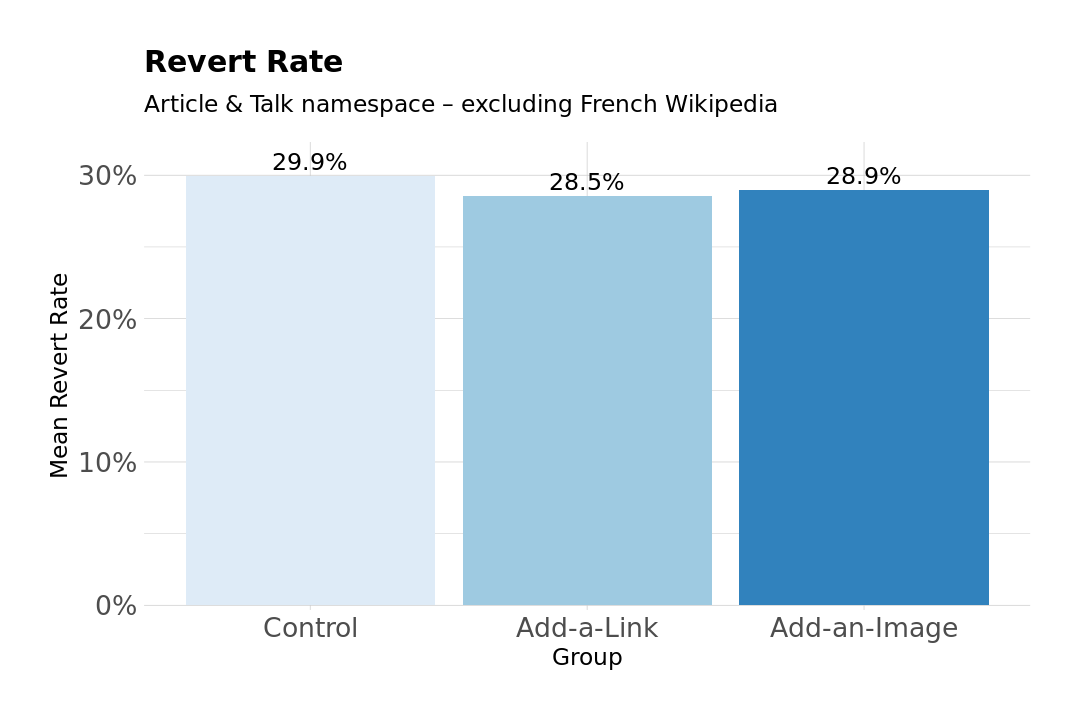

In [24]:
# Give me wider plots, please
options(repr.plot.width = 9, repr.plot.height = 6)

## Note to self: mutate() operates on a per-row basis, summarise() operates on the groups when using group_by()
rate.group.agg %>%
    ggplot(aes(x = exp_group, y = mean_prop_rev_article_edits, fill = exp_group)) +
        labs(
            title = 'Revert Rate',
            subtitle = 'Article & Talk namespace – excluding French Wikipedia',
            x = 'Group',
            y = 'Mean Revert Rate') +
        hrbrthemes::theme_ipsum("DejaVu Sans", base_size = 16, strip_text_face = "bold", strip_text_size = 18,
                            caption_size = 12, axis_title_size = 14, subtitle_size = 14,
                            axis_title_just = 'cm') +
        guides(fill = 'none') +
        scale_fill_brewer() +
        geom_col() +
        hrbrthemes::scale_y_percent(limits = c(0, 0.32)) +
        geom_text(aes(label = wmfdata::percent2(mean_prop_rev_article_edits)), nudge_y = 0.01, size = 5)
ggsave(
    'add-an-image-article-namespace-revert-rate-2022-experiment.png',
    path = 'graphs',
    width = 16, height = 9, units = "in", dpi = "print", bg = "white")

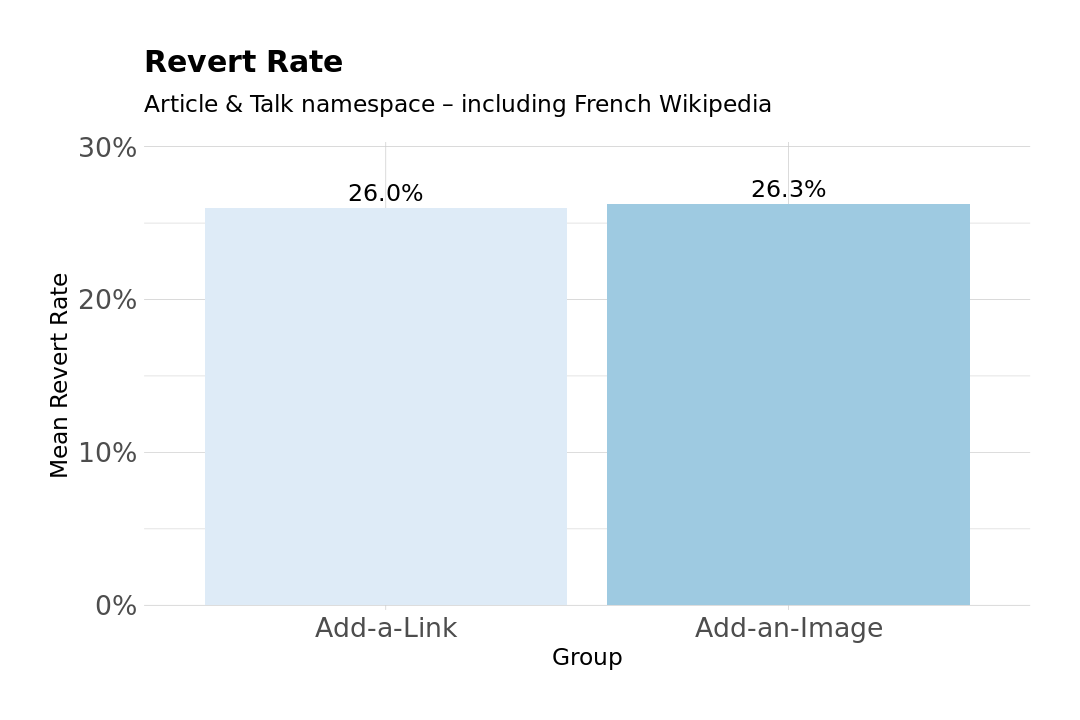

In [27]:
# Give me wider plots, please
options(repr.plot.width = 9, repr.plot.height = 6)

## Note to self: mutate() operates on a per-row basis, summarise() operates on the groups when using group_by()
rate.group.agg.structured %>%
    ggplot(aes(x = exp_group, y = mean_prop_rev_article_edits, fill = exp_group)) +
        labs(
            title = 'Revert Rate',
            subtitle = 'Article & Talk namespace – including French Wikipedia',
            x = 'Group',
            y = 'Mean Revert Rate') +
        hrbrthemes::theme_ipsum("DejaVu Sans", base_size = 16, strip_text_face = "bold", strip_text_size = 18,
                            caption_size = 12, axis_title_size = 14, subtitle_size = 14,
                            axis_title_just = 'cm') +
        guides(fill = 'none') +
        scale_fill_brewer() +
        geom_col() +
        hrbrthemes::scale_y_percent(limits = c(0, 0.3)) +
        geom_text(aes(label = wmfdata::percent2(mean_prop_rev_article_edits)), nudge_y = 0.01, size = 5)
ggsave(
    'add-an-image-article-namespace-revert-rate-2022-experiment-structured-tasks.png',
    path = 'graphs',
    width = 16, height = 9, units = "in", dpi = "print", bg = "white")